# UMA Raw data EDA

## Import Libraries

In [1]:
# analysis
import numpy as np
import pandas as pd
import requests

# other
import warnings

# visualisation libraries
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


## Import Data

In [2]:
# define authorisation parameters
task = {"username": "gometro-system-admin",
        "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
        "client_id": "gometro-uma-service",
        "grant_type": "password",
       }

# get authorisation credentials
endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
resp = requests.post(endpoint, data=task)

if (resp.status_code < 200) and (resp.status_code >= 300):
    raise ValueError('POST /tasks/ {}'.format(resp.status_code))

# get access token
token = resp.json()["access_token"]

# get headers
headers = {
    'Authorization': f'Bearer {token}',
}

# get data
endpoint = 'https://api.gometroapp.com/uma/v1/participants/9c3e37e8-5b51-463c-8688-4452e0c39dbf/events/2021-01-12'
response = requests.get(endpoint, headers=headers)

In [3]:
import pandas as pd
df = pd.DataFrame(response.json())
print(df.shape)
df.head()

(2338, 3)


timestamp                   type  \
0  2021-01-12T02:57:07.395Z    MemoryStatusChanged   
1  2021-01-12T02:58:07.395Z    MemoryStatusChanged   
2  2021-01-12T02:59:07.396Z    MemoryStatusChanged   
3  2021-01-12T02:59:52.575Z  DeviceSettingsUpdated   
4  2021-01-12T03:00:07.397Z    MemoryStatusChanged   

                                             payload  
0  {"availableMemory":424243200,"lowMemory":false...  
1  {"availableMemory":421408768,"lowMemory":false...  
2  {"availableMemory":420646912,"lowMemory":false...  
3  {"settings":[null,null,null,null,null,{"name":...  
4  {"availableMemory":418246656,"lowMemory":false...

## Assess Data

Assessing the event types we are receiving from the API

In [4]:
print(f"Number of categories: {len(df['type'].unique())}")
df['type'].value_counts()

Number of categories: 5


MemoryStatusChanged       1440
LocationChanged            455
DeviceSettingsUpdated      288
SatelliteStatusChanged     131
Warning                     24
Name: type, dtype: int64

Let us look at the payloads of the different `type` categories.

In [5]:
for category in df['type'].unique():
    print(category)
    print(df[df['type'] == category].iloc[0,2], '\n')

MemoryStatusChanged
{"availableMemory":424243200,"lowMemory":false,"threshold":150994944,"totalMemory":989736960} 

DeviceSettingsUpdated
{"settings":[null,null,null,null,null,{"name":"tracking.enabled","stringValue":"true","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true},{"name":"core.debug","stringValue":"false","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true,"mutable":false}]} 

SatelliteStatusChanged
{"satelliteCount":10} 

LocationChanged
{"provider":"gps","latitude":-33.868675,"longitude":18.53884833333333,"accuracy":2.5999999046325684,"bearing":319.80999755859375,"speed":0} 

Warning
{"message":"[DeviceEventsService.flush] Network Unavailable"} 



**Data Dictionary**

* `timestamp`: date and time waypoint was captured, UTC Timezome
* `type`: indicates the type of data contained in the payload
    * `LocationChanged`: Labels data with geographical observations in the payload
    * `SatelliteStatusChanged`: Labels data with the number of satellites connected to device
* `payload`: the payload of the data


The data required for this exercise is the data containing the waypoints, which is where the `type` category is `LocationChanged`

In [6]:
df_waypoints = df[
    df['type'] == 'LocationChanged'
]
print(df_waypoints.shape)
df_waypoints.head()

(455, 3)


timestamp             type  \
9   2021-01-12T03:03:35Z  LocationChanged   
16  2021-01-12T03:07:30Z  LocationChanged   
19  2021-01-12T03:09:39Z  LocationChanged   
30  2021-01-12T03:17:46Z  LocationChanged   
35  2021-01-12T03:21:04Z  LocationChanged   

                                              payload  
9   {"provider":"gps","latitude":-33.868675,"longi...  
16  {"provider":"gps","latitude":-33.8687266666666...  
19  {"provider":"gps","latitude":-33.8686466666666...  
30  {"provider":"gps","latitude":-33.8687233333333...  
35  {"provider":"gps","latitude":-33.8687250000000...

In [7]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df_waypoints['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



Unpacking the payload and updating the table

In [8]:
df_waypoints = unpack_payload(df_waypoints)
print(df_waypoints.shape)
df_waypoints.head()

(455, 7)


timestamp provider   latitude  longitude  accuracy     bearing  \
9   2021-01-12T03:03:35Z      gps -33.868675  18.538848       2.6  319.809998   
16  2021-01-12T03:07:30Z      gps -33.868727  18.538848       2.7  174.240005   
19  2021-01-12T03:09:39Z      gps -33.868647  18.538888       3.0  210.520004   
30  2021-01-12T03:17:46Z      gps -33.868723  18.538930       1.8   23.870001   
35  2021-01-12T03:21:04Z      gps -33.868725  18.538823       2.2  250.300003   

       speed  
9   0.000000  
16  0.117357  
19  0.000000  
30  0.028824  
35  0.407145

Data types and null values

In [9]:
df_waypoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 9 to 2331
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  455 non-null    object 
 1   provider   455 non-null    object 
 2   latitude   455 non-null    float64
 3   longitude  455 non-null    float64
 4   accuracy   455 non-null    float64
 5   bearing    455 non-null    float64
 6   speed      455 non-null    float64
dtypes: float64(5), object(2)
memory usage: 28.4+ KB


## Update Datatypes

### Variables to update

1. `timestamps`

In [10]:
df_waypoints['timestamp'] = pd.to_datetime(df_waypoints['timestamp'])
df_waypoints['timestamp'].head()

9    2021-01-12 03:03:35+00:00
16   2021-01-12 03:07:30+00:00
19   2021-01-12 03:09:39+00:00
30   2021-01-12 03:17:46+00:00
35   2021-01-12 03:21:04+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

## Make DateTime Index

In [11]:
df_waypoints = df_waypoints.set_index('timestamp')
df_waypoints.head()

provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-12 03:03:35+00:00      gps -33.868675  18.538848       2.6   
2021-01-12 03:07:30+00:00      gps -33.868727  18.538848       2.7   
2021-01-12 03:09:39+00:00      gps -33.868647  18.538888       3.0   
2021-01-12 03:17:46+00:00      gps -33.868723  18.538930       1.8   
2021-01-12 03:21:04+00:00      gps -33.868725  18.538823       2.2   

                              bearing     speed  
timestamp                                        
2021-01-12 03:03:35+00:00  319.809998  0.000000  
2021-01-12 03:07:30+00:00  174.240005  0.117357  
2021-01-12 03:09:39+00:00  210.520004  0.000000  
2021-01-12 03:17:46+00:00   23.870001  0.028824  
2021-01-12 03:21:04+00:00  250.300003  0.407145

In [12]:
df_waypoints.iloc[:100]

provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-12 03:03:35+00:00      gps -33.868675  18.538848       2.6   
2021-01-12 03:07:30+00:00      gps -33.868727  18.538848       2.7   
2021-01-12 03:09:39+00:00      gps -33.868647  18.538888       3.0   
2021-01-12 03:17:46+00:00      gps -33.868723  18.538930       1.8   
2021-01-12 03:21:04+00:00      gps -33.868725  18.538823       2.2   
...                            ...        ...        ...       ...   
2021-01-12 09:27:17+00:00      gps -33.867720  18.543702       2.9   
2021-01-12 09:27:24+00:00      gps -33.867648  18.543765       3.1   
2021-01-12 09:27:47+00:00      gps -33.867660  18.543700       3.1   
2021-01-12 09:27:56+00:00      gps -33.867682  18.543753       2.7   
2021-01-12 09:28:01+00:00      gps -33.867585  18.543982       2.7   

                              bearing     speed  
timestamp                                        
2021-01-12 03:03:35+00:00  319.809998  0.000000  
2021-01-12 03:07:30+00:00  174.240005  0.117357  
2021-01-12 03:09:39+00:00  210.520004  0.000000  
2021-01-12 03:17:46+00:00   23.870001  0.028824  
2021-01-12 03:21:04+00:00  250.300003  0.407145  
...                               ...       ...  
2021-01-12 09:27:17+00:00  124.309998  0.000000  
2021-01-12 09:27:24+00:00   72.669998  0.000000  
2021-01-12 09:27:47+00:00   60.189999  0.000000  
2021-01-12 09:27:56+00:00  118.949997  0.000000  
2021-01-12 09:28:01+00:00   51.639999  5.583707  

[100 rows x 6 columns]

In [13]:
df_waypoints.iloc[:100].to_csv('../../resources/data/interim/sample_standardised.csv')

## Making curves smoother

In [14]:
# select columns to make smoother
smooth_cols = [col for col
              in df_waypoints.select_dtypes(include='float64').columns
              if col not in ['latitude', 'longitude']]
smooth_cols

['accuracy', 'bearing', 'speed']

In [15]:
for col in smooth_cols:
    new_col = 'new_' + col
    df_waypoints[new_col] = df_waypoints[col].rolling(window=12).mean()

df_waypoints

provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-12 03:03:35+00:00      gps -33.868675  18.538848       2.6   
2021-01-12 03:07:30+00:00      gps -33.868727  18.538848       2.7   
2021-01-12 03:09:39+00:00      gps -33.868647  18.538888       3.0   
2021-01-12 03:17:46+00:00      gps -33.868723  18.538930       1.8   
2021-01-12 03:21:04+00:00      gps -33.868725  18.538823       2.2   
...                            ...        ...        ...       ...   
2021-01-13 01:14:34+00:00      gps -33.868600  18.539165       3.9   
2021-01-13 01:14:39+00:00      gps -33.868697  18.538960       3.8   
2021-01-13 01:15:21+00:00      gps -33.868682  18.538905       1.9   
2021-01-13 02:37:42+00:00      gps -33.868595  18.538890       1.8   
2021-01-13 02:52:35+00:00      gps -33.868682  18.538910       1.7   

                              bearing     speed  new_accuracy  new_bearing  \
timestamp                                                                    
2021-01-12 03:03:35+00:00  319.809998  0.000000           NaN          NaN   
2021-01-12 03:07:30+00:00  174.240005  0.117357           NaN          NaN   
2021-01-12 03:09:39+00:00  210.520004  0.000000           NaN          NaN   
2021-01-12 03:17:46+00:00   23.870001  0.028824           NaN          NaN   
2021-01-12 03:21:04+00:00  250.300003  0.407145           NaN          NaN   
...                               ...       ...           ...          ...   
2021-01-13 01:14:34+00:00  227.429993  1.130330      2.608333   151.652503   
2021-01-13 01:14:39+00:00  243.720001  4.907876      2.750000   167.229170   
2021-01-13 01:15:21+00:00  247.559998  0.000000      2.758333   159.368335   
2021-01-13 02:37:42+00:00  356.859985  0.000000      2.750000   168.988334   
2021-01-13 02:52:35+00:00  271.769989  0.177064      2.708333   188.372499   

                           new_speed  
timestamp                             
2021-01-12 03:03:35+00:00        NaN  
2021-01-12 03:07:30+00:00        NaN  
2021-01-12 03:09:39+00:00        NaN  
2021-01-12 03:17:46+00:00        NaN  
2021-01-12 03:21:04+00:00        NaN  
...                              ...  
2021-01-13 01:14:34+00:00   1.421062  
2021-01-13 01:14:39+00:00   1.830052  
2021-01-13 01:15:21+00:00   1.695881  
2021-01-13 02:37:42+00:00   1.611681  
2021-01-13 02:52:35+00:00   1.502045  

[455 rows x 9 columns]

Assessing `accuracy`

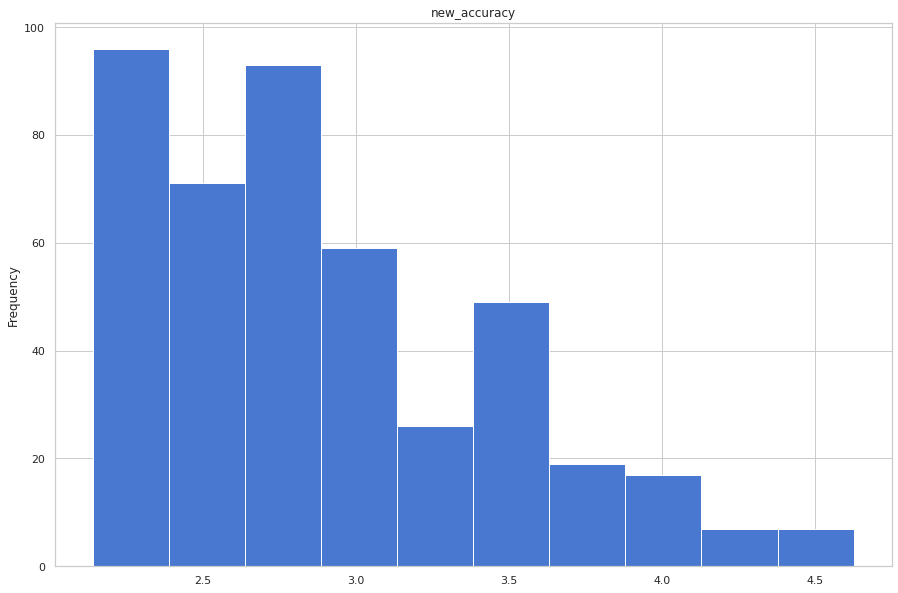

In [16]:
# column to visualise
col = 'new_accuracy'
kind='hist'

df_waypoints[col].plot(kind=kind)
plt.title(col)
plt.savefig(f'{col}_{kind}.png')
plt.show()

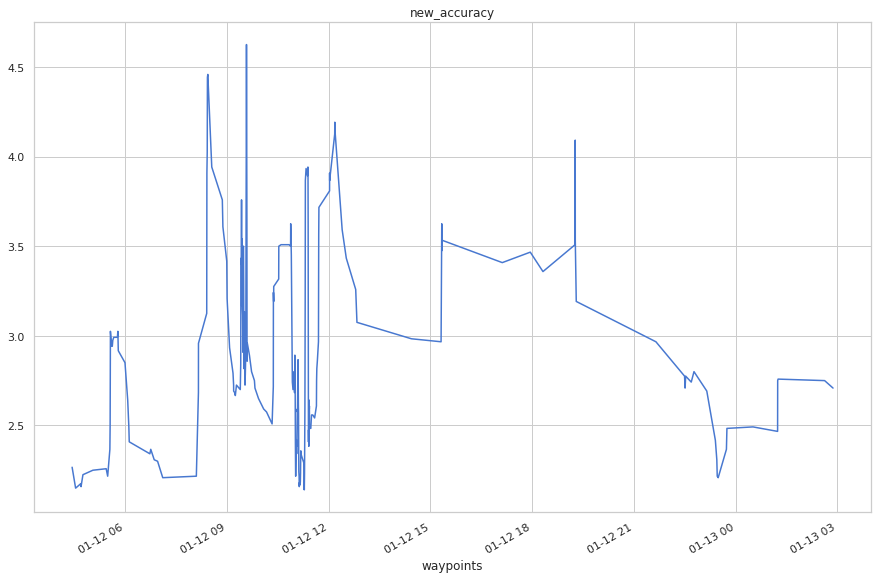

In [17]:
col = 'new_accuracy'
kind='line'

df_waypoints[col].plot(kind=kind)
plt.title(col)
plt.xlabel('waypoints')
plt.savefig(f'{col}_{kind}.png')
plt.show()

Assessing `bearing`

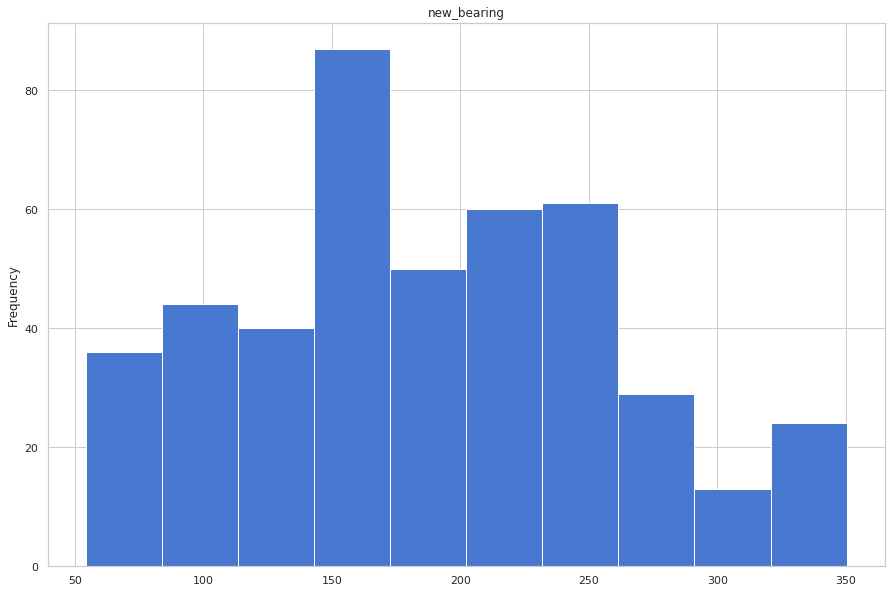

In [18]:
# column to visualise
col = 'new_bearing'
kind='hist'

df_waypoints[col].plot(kind=kind)
plt.title(col)
plt.savefig(f'{col}_{kind}.png')
plt.show()

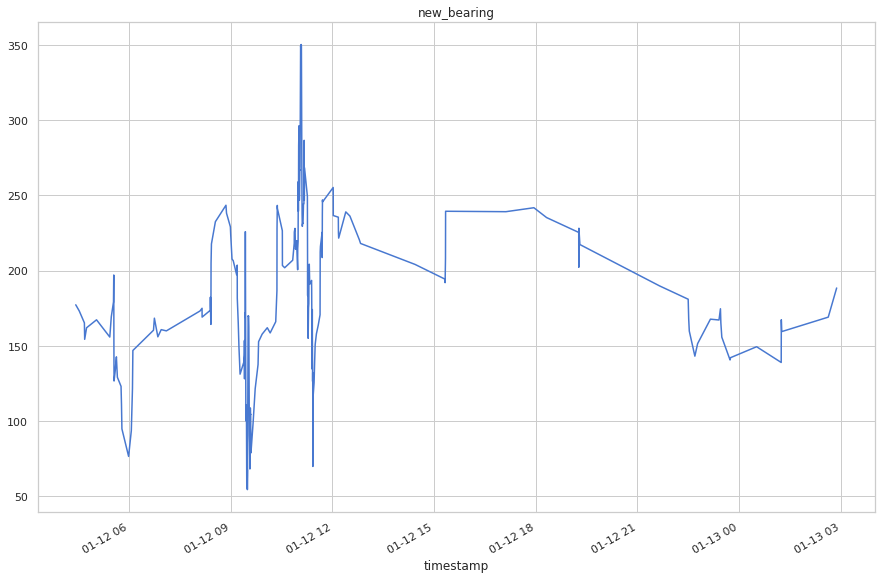

In [19]:
kind='line'

df_waypoints[col].plot(kind=kind)
plt.title(col)
plt.savefig(f'{col}_{kind}.png')
plt.show()

Assessing `speed`

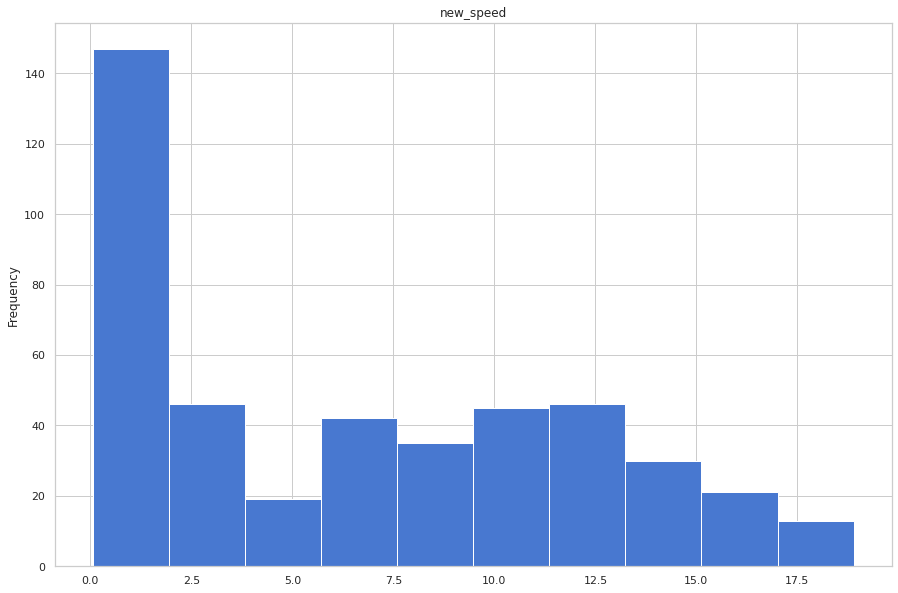

In [20]:
# column to visualise
col = 'new_speed'
kind='hist'

df_waypoints[col].plot(kind=kind)
plt.title(col)
plt.savefig(f'{col}_{kind}.png')
plt.show()

In [21]:
df_waypoints.index.shape

(455,)

In [22]:
df_waypoints['speed'].values.shape

(455,)

In [23]:
df_waypoints['speed']

timestamp
2021-01-12 03:03:35+00:00    0.000000
2021-01-12 03:07:30+00:00    0.117357
2021-01-12 03:09:39+00:00    0.000000
2021-01-12 03:17:46+00:00    0.028824
2021-01-12 03:21:04+00:00    0.407145
                               ...   
2021-01-13 01:14:34+00:00    1.130330
2021-01-13 01:14:39+00:00    4.907876
2021-01-13 01:15:21+00:00    0.000000
2021-01-13 02:37:42+00:00    0.000000
2021-01-13 02:52:35+00:00    0.177064
Name: speed, Length: 455, dtype: float64

In [24]:
df_waypoints.index

DatetimeIndex(['2021-01-12 03:03:35+00:00', '2021-01-12 03:07:30+00:00',
               '2021-01-12 03:09:39+00:00', '2021-01-12 03:17:46+00:00',
               '2021-01-12 03:21:04+00:00', '2021-01-12 03:22:35+00:00',
               '2021-01-12 03:23:51+00:00', '2021-01-12 03:46:37+00:00',
               '2021-01-12 03:50:29+00:00', '2021-01-12 04:04:35+00:00',
               ...
               '2021-01-12 23:29:21+00:00', '2021-01-12 23:43:56+00:00',
               '2021-01-12 23:44:49+00:00', '2021-01-13 00:30:56+00:00',
               '2021-01-13 01:14:29+00:00', '2021-01-13 01:14:34+00:00',
               '2021-01-13 01:14:39+00:00', '2021-01-13 01:15:21+00:00',
               '2021-01-13 02:37:42+00:00', '2021-01-13 02:52:35+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=455, freq=None)

In [25]:
df_waypoints.loc['2021-01-12']['new_speed']

timestamp
2021-01-12 03:03:35+00:00         NaN
2021-01-12 03:07:30+00:00         NaN
2021-01-12 03:09:39+00:00         NaN
2021-01-12 03:17:46+00:00         NaN
2021-01-12 03:21:04+00:00         NaN
                               ...   
2021-01-12 23:26:56+00:00    0.715292
2021-01-12 23:27:40+00:00    0.506787
2021-01-12 23:29:21+00:00    0.506787
2021-01-12 23:43:56+00:00    0.486884
2021-01-12 23:44:49+00:00    0.383082
Name: new_speed, Length: 448, dtype: float64

Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which e

Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1274 ticks ([18639.14513888889, ..., 18640.029166666667]), which e

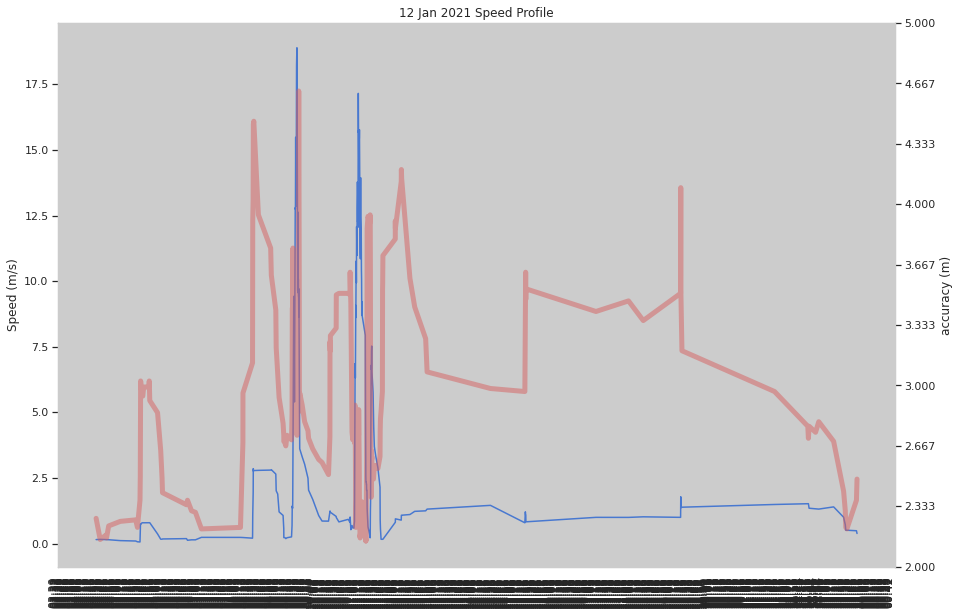

In [28]:

# define first axis
fig, ax1 = plt.subplots()
ax1.plot(df_waypoints.loc['2021-01-12']['new_speed'], linestyle='-', color='b', label='speed')
ax1.set_ylabel('Speed (m/s)')
ax1.set_title('12 Jan 2021 Speed Profile')

# define 2nd axis
ax2 = ax1.twinx()
ax2.plot(df_waypoints.loc['2021-01-12']['new_accuracy'], linestyle='-', color='r',
         alpha=0.5, linewidth=5, label = 'accuracy')
ax2.set_ylabel(r"accuracy (m)")
ax2.grid(None)

# align axes
# ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))

# Determine which plot has finer grid. Set pointers accordingly
l1 = len(ax1.get_yticks())
l2 = len(ax2.get_yticks())
if l1 > l2:
    a = ax1
    b = ax2
    l = l1
else:
    a = ax2
    b = ax1
    l = l2

# Respace grid of 'b' axis to match 'a' axis
b_ticks = np.linspace(b.get_yticks()[0],b.get_yticks()[-1],l)
b.set_yticks(b_ticks)

## Set time format and the interval of ticks (every 15 minutes)
xlocator = mdates.MinuteLocator(interval = 1)
ax1.xaxis.set_major_locator(xlocator)

## Format xtick labels as HH:MM
xformatter = mdates.DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
# plt.xticks(rotation=90)
plt.setp(ax1.get_xticklabels(), rotation=90, ha='right')

plt.show()

Create a function that generates a data validation plot that will be used by the technical team to validate the results obtained from an algorithm

inputs
* `df` (*pandas.DataFrame*): a table with the raw trip data
* `col` (*str*):  name of column to visualise over time
* `figures_dir` (*str*): folder in the `repo_root/resources/figures/` to save the figure in
* `participant_id` (*str*): 
* `date` (*str*): name of file
    
outputs
* Visualisation:
    * size: TBD (Big Enough to show minutes clearly)
    * Title: "{`col`} profile over time on {`date`}"
    * y_label: "{`col`}_`<units>`"
    * x_label: "time"
    * x_ticks: 1 min interval
* file_path: "{`figures_dir`}/{`participant_id`}/{`date`}_{`col`}_vs_{`time`}"